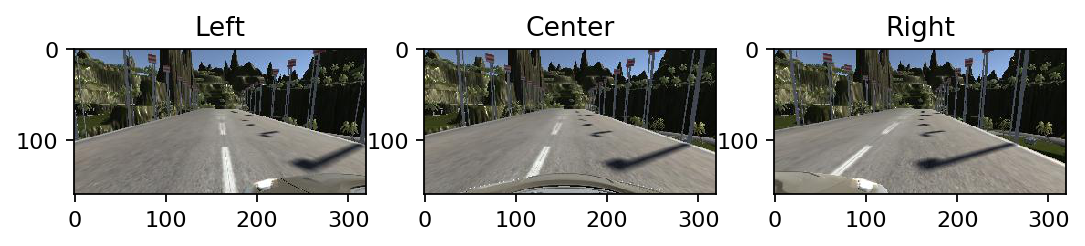

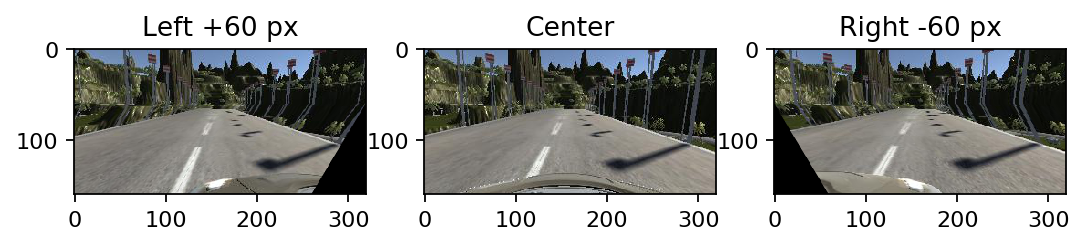

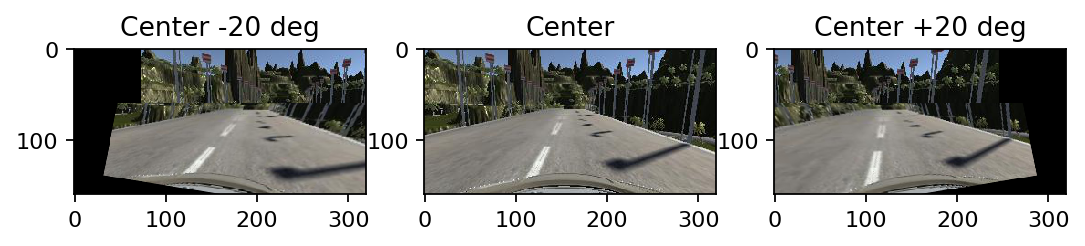

In [1]:
%matplotlib inline

import csv
import cv2
import math
#import sklearn
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
#from random import shuffle
#from skimage import exposure
from skimage import transform 
#from sklearn.model_selection import train_test_split

def transform_image(image, translation_distance, rotation_angle, camera_distance=200, horizon=60):
    """Return an image with perspective transformed as though the
    camera had been translated sideways and then rotated about the 
    vertical axis. The transformation assumes that the original image
    lies on the x-y plane, that the camera points down the y axis, that
    the camera height above the x-y plane is equal to the y dimension
    of the image, and that the camera is at a specified y projected 
    distance from points imaged at the bootom of the original image.
    The image is rotated about the z axis passing through the 
    center bottom point of the image following translation. The 
    rotation operation may introduce distortion.

    Args:
        image (numpy[Y,X,C]): Input image.
        translation_distance (float): Distance to translate the
          image in units of pixels. 
        rotation_angle (float): The rotation angle in radians.
        camera_distance (float): Camera y distance from the points 
          imaged by lower edge of original image. Units are distances
          equivalent to the width of a pixel along the lower image edge. 

    Returns:
        (numpy[Y,X,C]) Output image.

    """   
    
    image = np.copy(image)
    rotation_angle *= math.pi/180
    
    fix = False
    if fix:
        rotation_angle *= -1
        translation_distance *= -1

    # measure the source image
    y, x, c = image.shape
    y -= horizon

    # 3 space image frame is on x-z plane with camera on y axis
    # camera is at y=-yc where yc is distance from origin to camera
    # ground is at z=-y where y is image height

    # 3 space coordinates of lower image frame corners are:
    # (x0l, 0, y)
    # (x1l, 0, y)
    x0l = -x/2
    x1l =  x/2

    # Translate the lower image frame corners
    x0l += translation_distance
    x1l += translation_distance

    # Rotate the lower image frame corners on z axis
    # this moves y coordinates off the plane
    x0n =  x0l*math.cos(rotation_angle)
    y0n = -x0l*math.sin(rotation_angle)
    x1n =  x1l*math.cos(rotation_angle)
    y1n = -x1l*math.sin(rotation_angle)

    # Project ray from camera to lower corners onto the xy plane
    # we want these points in the original image to move to the lower
    # image corners following the perspective transformation
    s0 = camera_distance/(camera_distance+y0n)
    s1 = camera_distance/(camera_distance+y1n)

    x0s = x0n*s0
    x1s = x1n*s1
    z0s = y*s0
    z1s = y*s1

    # Translation has no effect on the upper points, but rotation
    # causes the upper corners to undergo a nonlinear horizontal
    # transformation. For large caera_distance/x the transformation is 
    # approximately a linear transformation. Since we don't have 
    # a good way to implement the nonlinear operation, we'll
    # aproximate as a translation.
    dx = math.tan(rotation_angle)*camera_distance 
   
    idx = round(dx)

    if fix:
        idx = -idx    
    
    if(idx>0):   

        # Fix upper images
        image[:horizon,:-idx,:] = image[:horizon,idx:,:]
        image[:horizon,-idx:,:] = 0
        
    if(idx<0): 
        
        image[:horizon,-idx:,:] = image[:horizon,:idx,:]  
        image[:horizon,:-idx,:] = 0

    # Specify source points
    src = np.float32([[dx,0],[x+dx,0],[x0s+x/2,z0s],[x1s+x/2,z1s]])       

    # Specify destination points 
    dst = np.float32([[0,0],[x,0],[0,y],[x,y]])

    if fix:
        
        # Build transform matix
        transform = cv2.getPerspectiveTransform(dst,src)
        
    else:
        
        # Build transform matix
        transform = cv2.getPerspectiveTransform(src,dst)
    
    # Apply the transform
    image[horizon:,:,:] = cv2.warpPerspective(image[horizon:,:,:],transform,(x,y))

    return(image)

def get_augmented_image(sample, translation_distance=0, rotation_angle=0, camera_spacing=60):
    
    # default to center camera
    camera = 0
    
    # if left camera is closer...
    if(translation_distance<-camera_spacing/2):
        
        # use the left camera
        camera = 1
        
        # adjust the image offset
        translation_distance += camera_spacing
        
    # if right camera is closer...
    if(translation_distance>camera_spacing/2):
    
        # use the right camera
        camera = 2
        
        # adjust the image offset
        translation_distance -= camera_spacing
        
    # load camera image
    image = plt.imread(sample[camera])
    
    # transform the image
    image = transform_image(image, translation_distance, rotation_angle)
    
    return image
    
def load_log_images(path, n):
  
    images = []
    names  = []
    with open(path+'/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        [next(reader) for i in range(n+1)]
        line = next(reader)
        for i in range(3):
            s = line[i].strip().replace('\\','/')
            s = s.split('/')[-1]
            name = path + '/IMG/' + s
            image = plt.imread(name)
            images.append(image)
            names.append(name)
    return(images, names)

def draw_sample_images(path, n):

    # Get image set
    images, names = load_log_images(path, n)
    
    left = images[1]
    center = images[0]
    right = images[2]
    
    plt.figure(num=None, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')
    plt.subplot('131'),plt.imshow(left  ),plt.title('Left')
    plt.subplot('132'),plt.imshow(center),plt.title('Center')
    plt.subplot('133'),plt.imshow(right ),plt.title('Right')
    
    leftc = transform_image(left, translation_distance=+60, rotation_angle=0)
    rightc = transform_image(right, translation_distance=-60, rotation_angle=0)
    
    plt.figure(num=None, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')
    plt.subplot('131'),plt.imshow(leftc),plt.title('Left +60 px')
    plt.subplot('132'),plt.imshow(center),plt.title('Center')
    plt.subplot('133'),plt.imshow(rightc),plt.title('Right -60 px')
    
    centern = transform_image(center, translation_distance=0, rotation_angle=-20)
    centerp = transform_image(center, translation_distance=0, rotation_angle= 20)
    
    plt.figure(num=None, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')
    plt.subplot('131'),plt.imshow(centern),plt.title('Center -20 deg')
    plt.subplot('132'),plt.imshow(center),plt.title('Center')
    plt.subplot('133'),plt.imshow(centerp),plt.title('Center +20 deg')

draw_sample_images('Track2', 1010)

In [2]:
%matplotlib inline

import csv
import cv2
import math
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import shuffle
from skimage import exposure
from skimage import transform 

from sklearn.model_selection import train_test_split

def load_sample_list(paths, test_size=0.1, rate=1):
  
    samples = []
    for path in paths:
        with open(path+'/driving_log.csv') as csvfile:
            reader = csv.reader(csvfile)
            next(reader)
            r = 0
            for line in reader:
                r += rate
                while r >= 1:
                    r -= 1
                    for i in range(3):
                        s = line[i].strip().replace('\\','/')
                        s = s.split('/')[-1]
                        line[i] = path + '/IMG/' + s
                    samples.append(line)
    
    shuffle(samples)
    
    train_samples, validation_samples = train_test_split(samples, test_size=test_size) 
    
    return(train_samples, validation_samples)

def generate_samples(samples, batch_size=32):
    
    steering_adj = 0.2 
    num_samples = len(samples)
    
    while 1:
        shuffle(samples)  
        for offset in range(0, num_samples, batch_size):
            x = []
            y = []            
            for batch_sample in samples[offset:offset+batch_size]:
                center, left, right, steering, throttle, brake, speed = batch_sample
                steering  = float(steering)
                
                rotation_angle = np.random.uniform(-10,10)
                translation_distance = np.random.uniform(-90,90)
                flip = np.random.randint(1)
                
                image = get_augmented_image(batch_sample[0:3], translation_distance, rotation_angle)
                
                image = image[60:140,60:300,:]
                
                steering -= translation_distance/60 * steering_adj
                steering -= rotation_angle/25 * steering_adj
                
                if flip:        
                    
                    image = np.fliplr(image) 
                    steering = -steering
                    
                x.append(image)
                y.append(steering)
                
            yield(np.array(x),np.array(y))

In [3]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Cropping2D, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

#t1, v1 = load_sample_list(['Track1Forward', 'Track2Forward', 'Track1Reverse', 'Track2Reverse'], rate=.1)
#t2, v2 = load_sample_list(['Track1Recovery','Track2Recovery'], rate=.5)

#train = t1+t2
#valid = v1+v2

train, valid = load_sample_list(['data'], rate=.5)

# compile and train the model using the generator function
train_generator = generate_samples(train, batch_size=32)
validation_generator = generate_samples(valid, batch_size=32)

rate = .5
    
model = Sequential()

model.add(BatchNormalization(input_shape=(80, 240, 3)))

model.add(Convolution2D(24,5,5,subsample=(2,2),activation='elu', init='glorot_uniform', bias=False))
model.add(BatchNormalization())

model.add(Convolution2D(36,5,5,subsample=(2,2),activation='elu', init='glorot_uniform', bias=False))
model.add(BatchNormalization())

model.add(Convolution2D(48,5,5,subsample=(2,2),activation='elu', init='glorot_uniform', bias=False))
model.add(BatchNormalization())

model.add(Convolution2D(64,3,3,activation='elu', init='glorot_uniform', bias=False))
model.add(BatchNormalization())

model.add(Convolution2D(64,3,3,activation='elu', init='glorot_uniform', bias=False))
model.add(BatchNormalization())

model.add(Flatten())

bias = False
model.add(Dropout(rate))
model.add(Dense(1154, activation='elu', init='glorot_uniform', bias=bias))
model.add(BatchNormalization())

model.add(Dropout(rate))
model.add(Dense( 100, activation='elu',  init='glorot_uniform', bias=bias))
model.add(BatchNormalization())

model.add(Dropout(rate))          
model.add(Dense(  50, activation='elu', init='glorot_uniform', bias=bias))
model.add(BatchNormalization())

model.add(Dropout(rate))
model.add(Dense(  10, activation='elu', init='glorot_uniform', bias=bias))
model.add(BatchNormalization())

model.add(Dense(   1, activation='linear', init='glorot_uniform'))

model.compile(loss='mse', optimizer='adam')
epochs = 10
model_save = ModelCheckpoint(filepath='model.h5', mode='auto', period=1)
model.fit_generator(train_generator, samples_per_epoch= \
            len(train), validation_data=validation_generator, \
            nb_val_samples=len(valid), nb_epoch=epochs, callbacks=[model_save])


Using TensorFlow backend.


Epoch 1/10
3616/3616 [==============================] - 11s - loss: 0.4752 - val_loss: 0.1306
Epoch 2/10
3616/3616 [==============================] - 7s - loss: 0.1277 - val_loss: 0.0525
Epoch 3/10
3616/3616 [==============================] - 7s - loss: 0.0749 - val_loss: 0.0339
Epoch 4/10
3616/3616 [==============================] - 7s - loss: 0.0603 - val_loss: 0.0253
Epoch 5/10
3616/3616 [==============================] - 7s - loss: 0.0473 - val_loss: 0.0252
Epoch 6/10
3616/3616 [==============================] - 7s - loss: 0.0454 - val_loss: 0.0241
Epoch 7/10
3616/3616 [==============================] - 7s - loss: 0.0384 - val_loss: 0.0246
Epoch 8/10
3616/3616 [==============================] - 7s - loss: 0.0356 - val_loss: 0.0215
Epoch 9/10
3616/3616 [==============================] - 7s - loss: 0.0329 - val_loss: 0.0227
Epoch 10/10
3616/3616 [==============================] - 7s - loss: 0.0312 - val_loss: 0.0186
